In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
class Dataset:
    def __init__(self):
        self.X = None
        self.X_t = None
        self.y_hat = None
        self.df = None
        self.w = None
    def normalize(self):
        mean_x = np.nanmean(X, axis=1)
        std_x = np.nanstd(X, axis=1)
        std_x[std_x == 0] = 1
        self.X = (self.X - mean_x[:, np.newaxis]) / std_x[:, np.newaxis]

In [79]:
trainset = Dataset()
testset = Dataset()

In [80]:
trainset.df = pd.read_csv('train_datas_0.csv', dtype='float', na_values='-')
trainset.df1 = pd.read_csv('train_datas_1.csv').apply(pd.to_numeric, errors='coerce')
testset.df = pd.read_csv('test_datas.csv', dtype='float', na_values='-')

In [401]:
DIM = 15*9 + 3 # with 2nd-order term, hour, day and bias

In [402]:
def fill_nan_with_mean():
    trainset.df1.dropna(how='all')
    for s in (trainset.df, trainset.df1, testset.df):
        s[s.columns] = s[s.columns].fillna(s[s.columns].mean())
fill_nan_with_mean()

In [403]:
def preprocess_training_data():
    d = DIM
    n = len(trainset.df) - 9 #+ len(trainset.df1) - 9
    X = np.zeros((d, n))
    y_hat = np.zeros(n)

    # extract feature
    hr = 0
    day = 0
    for i in range(len(trainset.df)-9):
        X[0:15*9, i] = trainset.df.iloc[i:i+9].to_numpy().flatten()
        #X[15*9:15*9*2, i] = X[0:15*9, i] ** 2
        X[15*9, i] = hr
        X[15*9+1, i] = day
        X[15*9+2, i] = 1 # bias
        hr = (hr + 1) % 24
        day = (day+1) % 365
        y_hat[i] = trainset.df.iloc[i+9]['PM2.5']
#    hr = 0
#     off = len(trainset.df)-9
#     for i in range(len(trainset.df1)-9):
#         X[0:15*9, off+i] = trainset.df1.iloc[i:i+9].to_numpy().flatten()
#         X[15*9:15*9*2, off+i] = X[0:15*9, off+i] ** 2
#         X[15*9*2, off+i] = hr
#         hr = (hr + 1) % 24
#         y_hat[i] = trainset.df1.iloc[i+9]['PM2.5']

    trainset.X = X
    trainset.X_t = X.T
    trainset.y_hat = y_hat
    #trainset.normalize()

preprocess_training_data()

In [404]:
#np.savetxt('a', trainset.X, fmt='%.2f', delimiter=',')

In [409]:
def train(X, y_hat, lr, reg, num_iter):
    # training
    X_t = X.T
    d, n = X.shape
    w = np.zeros(d)
    sum_grad_sq = 0 # adagrad
    loss = np.zeros(num_iter)
    for i in range(num_iter):
        # L(w) = || X^T - y^ ||^2 + reg * ||w||^2
        # ∇L(w) = 2 * X * (X^T * w - y^) + 2 * reg * w
        y = np.dot(X_t, w)
        loss[i] = np.inner(y - y_hat, y - y_hat) + reg * np.linalg.norm(w, 1)
        grad = np.dot(X, y - y_hat) + reg * w
        sum_grad_sq += np.inner(grad, grad)
        w = w - lr / np.sqrt(sum_grad_sq) * grad
        if i == num_iter-1:
            print('i',i)
            #print('std_x',std_x)
            #print('rr',rr)
            #print('Xt',X_t)
            print('y', y)
            print('y_hat', y_hat)
            #print('grad', grad)
            print('w', w)
            print('loss', loss[i])
            print()
    plt.plot(loss)
    return w

In [410]:
def validate(X, y_hat, w):
    # validate
    X_t = X.T
    y = np.dot(X_t, w)
    return np.inner(y - y_hat, y - y_hat)

lr 0.1 reg 0
i 9999
y [30.2  27.14 31.33 ... 14.34 13.12 18.9 ]
y_hat [26. 27. 24. ... 12. 17. 19.]
w [ 0.01 -0.    0.    0.   -0.    0.01 -0.    0.   -0.   -0.02  0.04  0.
  0.   -0.   -0.    0.01 -0.    0.    0.01 -0.    0.   -0.    0.   -0.
 -0.02  0.04 -0.    0.   -0.    0.    0.01 -0.02 -0.01  0.01  0.    0.01
 -0.    0.   -0.   -0.01  0.06  0.    0.   -0.   -0.01  0.01 -0.   -0.
  0.    0.   -0.01  0.    0.   -0.   -0.02  0.04  0.   -0.   -0.   -0.
  0.01 -0.01 -0.01  0.    0.   -0.02  0.    0.   -0.   -0.03  0.05  0.
  0.   -0.   -0.01  0.01 -0.01 -0.01  0.   -0.   -0.02  0.    0.   -0.
 -0.03  0.07  0.    0.   -0.   -0.02  0.01 -0.01 -0.02 -0.   -0.   -0.02
  0.    0.   -0.   -0.04  0.09 -0.    0.   -0.01 -0.01  0.   -0.03 -0.03
 -0.   -0.    0.01  0.    0.   -0.   -0.01  0.16 -0.   -0.   -0.01  0.
  0.01 -0.01  0.06  0.07  0.    0.04  0.01  0.    0.    0.22  0.35 -0.
 -0.   -0.01  0.05  0.02  0.    0.  ]
loss 244646.89380003154

validate loss 64441.11305741157

lr 0.05 reg 0
i

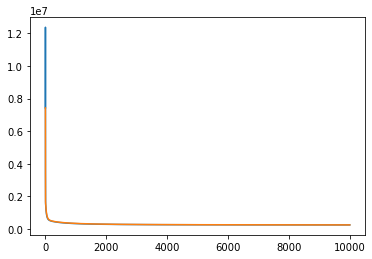

In [428]:
def run():
    X = trainset.X
    y_hat = trainset.y_hat
    d, n = X.shape
    idx_validate = pd.Series([False] * n)
    idx_validate[0:1000] = True
    
    lr = 1e-1 # learning rate
    reg = 1e-3 # regularization term, lasso or ridge
    
    for lr in (0.1, 0.05):
        for reg in (0,):
            print('lr',lr,'reg',reg)
            testset.w = train(X[:, ~idx_validate], y_hat[~idx_validate], lr, reg, 10000)
            loss = validate(X[:, idx_validate], y_hat[idx_validate], testset.w)
            print('validate loss', loss)
            print()
run()

In [388]:
np.set_printoptions(threshold=1e3, suppress=True, precision=2)
d,n=trainset.X.shape
#np.concatenate((trainset.X.T.dot(testset.w), trainset.y_hat)).reshape((n,2))
np.vstack(trainset.X.T.dot(testset.w) - trainset.y_hat)

array([[10.7 ],
       [15.15],
       [ 2.56],
       ...,
       [ 4.5 ],
       [-1.53],
       [ 2.35]])

In [429]:
def preprocess_testing_data():
    d = DIM
    n = (len(testset.df) + 8) // 9
    X = np.zeros((d, n))
    X[d-1, :] = 1 # for bias

    # extract feature
    hr = 0
    for i in range(n):
        X[0:15*9, i] = testset.df.iloc[i*9:(i+1)*9].to_numpy().flatten()
        #X[15*9:15*9*2, i] = X[0:15*9, i] ** 2
        X[15*9, i] = hr
        hr = (hr +1 )%24

    testset.X = X
    testset.X_t = X.T

    #testset.normalize()

preprocess_testing_data()

In [430]:
def predict():
    y_pred = np.dot(testset.X_t, testset.w).round(0).astype(int)
    return y_pred
y_pred = predict()
y_pred

array([16, 17, 19, 33, 22, 35, 46, 65, 71, 54, 47, 47, 60, 52, 40, 45, 33,
       26, 24, 33, 33, 30, 27, 23, 24, 16,  7,  9, 20, 21, 26, 18, 20, 17,
       23, 25, 19, 19,  8,  7, 14, 25, 22, 25, 20, 29, 32, 33, 34, 31, 45,
       34, 37, 39, 22, 23, 17, 15,  6,  4,  3,  0,  7,  8, 12,  7,  5,  9,
       21, 22, 28, 30, 24, 20, 49, 24, 21, 16, 17, 16, 16, 14,  8, 11, 19,
       24, 10,  8,  8,  8, 14, 12, 16, 20, 26, 30, 38, 35, 27, 22, 51, 34,
       24, 11, -7, 28, 28, 19, 15,  5,  4, 13, 18, 14, 15, 20, 23, 23, 25,
       21, 20, 25, 26, 29, 23, 27, 25, 23, 40, 52, 38, 11, 12,  8, 23, 17,
       16, 20, 26, 17, 29, 31, 26, 13, 12, 16, 21, 27, 27, 19,  2,  8, 10,
       21, 24, 25,  6, 15, 25, 26, 24, 24, 13, 10,  6, 16, 29, 32, 32, 28,
       37, 18,  3, 14, 15, 20, 24, 21, 29, 27, 23, 27, 27, 36, 29, 29, 20,
       27, 33, 32, 25, 26, 25, 19, 21, 23, 20, 28, 22, 29, 37, 24, 23, 23,
       18, 11, 10,  6,  4, 17, 18, 18, 15, 16, 22, 21, 14, 16, 19, 24, 23,
       30, 20, 17, 21, 19

In [431]:
pred_df = pd.DataFrame({
    'id': ['id_' + str(i) for i in range(500)],
    'value': y_pred
})
pred_df.to_csv('submission.csv', index=False)

In [419]:
def closed_form_solution():
    w_hat, residuals, rank, s  = np.linalg.lstsq(trainset.X_t, trainset.y_hat)
    #print(residuals, rank, s)
    X = trainset.X
    X_t = trainset.X_t
    y_hat = trainset.y_hat
    assert w_hat.shape[0] == DIM
    print('w_hat',w_hat[:15*9].reshape((15,9)),w_hat[15*9:])
    print('w',testset.w[:15*9].reshape((15,9)),testset.w[15*9:])
    print('loss', np.linalg.norm(trainset.X_t.dot(w_hat) - trainset.y_hat)**2)
closed_form_solution()

w_hat [[ 0.13  2.18 -2.18  2.19 -0.48  0.   -0.02 -0.62 -0.41]
 [-0.01  0.01 -0.23  0.    0.33  0.04 -0.06 -2.43  2.48]
 [-2.5  -0.7  -0.    0.17 -0.9  -0.41 -0.01  0.03 -0.14]
 [ 0.   -0.43 -0.04  0.12 -1.52  1.44 -1.44  1.6   0.03]
 [-1.77  1.33  1.41  0.01  0.04 -0.28  0.    0.15  0.  ]
 [ 0.06  0.9  -0.87  0.85 -0.62  0.01  0.76  0.28 -0.55]
 [-0.   -0.01  0.14 -0.   -0.39 -0.05 -0.13 -0.94  0.92]
 [-0.91  0.11 -0.01  0.34 -1.99 -0.35 -0.02  0.04 -0.3 ]
 [ 0.    0.3   0.09  0.09 -2.59  2.56 -2.54 -0.48 -0.03]
 [ 0.53 -0.87 -0.79  0.    0.03  0.69  0.    0.27 -0.07]
 [ 0.11 -1.26  1.24 -1.24  0.34 -0.01  0.63 -0.68 -0.06]
 [-0.07  0.08  0.27  0.   -0.27  0.04 -0.27 -0.87  0.87]
 [-1.02 -0.23 -0.06 -0.14 -0.74 -0.36 -0.02  0.19 -0.01]
 [-0.   -0.69 -0.3   0.12  0.11 -0.08  0.24  0.6   0.09]
 [ 2.58  0.13 -1.52  0.15  0.49 -1.64 -0.    0.63  0.25]] [0.02 0.   7.4 ]
w [[ 0.01 -0.01 -0.    0.   -0.    0.01  0.    0.   -0.  ]
 [-0.02  0.01 -0.    0.   -0.01  0.01  0.    0.01  0.02]
 [ 0.

/home/soyccan/anaconda3/envs/ml-hw1-tmp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
